In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold
from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler
from ray.train import report
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
import torch.nn.functional as F
import joblib
import os
from scipy.stats import mannwhitneyu

In [4]:
# Import training and testing sets
X_train = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_train.csv")
X_validate = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_validate.csv")
X_test = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/X_test.csv")
y_train = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_train.csv").squeeze()
y_validate = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_validate.csv").squeeze()
y_test = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/y_test.csv").squeeze()

# 1. Hyperparameter tuning using training set 5 folds cross validation

## 1.1 Raytune 1 using wide seach space to train 10 models

In [ ]:

class MLP(nn.Module):
    def __init__(self, input_dim, layer_sizes):
        super().__init__()
        layers = []
        prev = input_dim
        for h in layer_sizes:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(negative_slope=0.01)]
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_mlp_cv(config, data=None):
    X, y = data
    X_np = np.array(X)
    y = np.array(y)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Identify if cuda is available to use GPU
    if torch.cuda.is_available() == True:
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device: {device}")

    val_losses = []
    val_accuracies = []
    val_f1s = []
    criterion = nn.BCEWithLogitsLoss()

    for train_idx, val_idx in kf.split(X_np, y):
        X_train_df, X_val_df = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y[train_idx], y[val_idx]

        # scalling the datasets
        scaler = StandardScaler()

        scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                           "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]
        X_train_scaled = X_train_df.copy()
        X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
        X_val_scaled = X_val_df.copy()
        X_val_scaled[scaled_features] = scaler.transform(X_val_scaled[scaled_features])

        X_train_scaled = np.array(X_train_scaled)
        X_val_scaled = np.array(X_val_scaled)
        
        # load datatset into GPU
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=config["batch_size"],
                                                   shuffle=True)

        # Build model from config
        layers = [config["layer_1_size"]]
        if config["n_layers"] >= 2:
            layers.append(config["layer_2_size"])
        if config["n_layers"] == 3:
            layers.append(config["layer_3_size"])
        if config["n_layers"] == 4:
            layers.append(config["layer_4_size"])

        model = MLP(input_dim=X.shape[1], layer_sizes=layers).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])


        best_val_loss = float("inf")
        patience = 5
        patience_counter = 0

        for epoch in range(250):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb.float())
                loss.backward()
                optimizer.step()


            # Validation
            model.eval()
            with torch.no_grad():
                val_out = model(X_val_tensor)
                val_loss = criterion(val_out, y_val_tensor).item()
                probs = torch.sigmoid(val_out).cpu().numpy()
                preds = (probs > 0.5).astype(int).squeeze()
                true = y_val_tensor.cpu().numpy().astype(int).squeeze()
                acc = accuracy_score(true, preds)
                f1 = f1_score(true, preds, average="weighted")


            print(f"Epoch number {epoch} completed")

            # early stopper if patience reached
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_acc = acc
                best_f1 = f1
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Patience reached")
                    break

        val_losses.append(best_val_loss)
        val_accuracies.append(best_acc)
        val_f1s.append(best_f1)

        # Clean the GPU memory between each model
        del model
        torch.cuda.empty_cache()

    # Report mean metrics to Ray Tune

    metric = {
        "val_loss" : np.mean(val_losses),
        "accuracy" : np.mean(val_accuracies),
        "f1_score" : np.mean(val_f1s)
        }

    tune.report(metrics=metric)


# Create search space

search_space = {
    "n_layers": tune.choice([3, 4]),
    "layer_1_size": tune.choice([512, 256, 128, 64]),
    "layer_2_size": tune.choice([512, 256, 128, 64]),
    "layer_3_size": tune.choice([512, 256, 128, 64]),
    "layer_4_size": tune.choice([512, 256, 128, 64]),
    "lr": tune.loguniform(1e-4, 1e-2),
    "batch_size": tune.choice([32, 64, 128])
}



tune.run(
    tune.with_parameters(train_mlp_cv, data=(X_train, y_train)),
    config=search_space,
    num_samples=10,
    scheduler=ASHAScheduler(metric="val_loss", mode="min"),
    search_alg=OptunaSearch(metric="val_loss", mode="min"),
    resources_per_trial={"cpu": 2, "gpu": 0.5},
    max_concurrent_trials=2,
    storage_path="/home/s2106664/msc_project/model_training/MLP_sigmoid/ray_tune_results"
)

## 1.2 Raytune 1 using narrow search space to train 20 models

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, layer_sizes):
        super().__init__()
        layers = []
        prev = input_dim
        for h in layer_sizes:
            layers += [nn.Linear(prev, h), nn.LeakyReLU(negative_slope=0.01)]
            prev = h
        layers.append(nn.Linear(prev, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def train_mlp_cv(config, data=None):
    X, y = data
    X_np = np.array(X)
    y = np.array(y)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Identify if cuda is available to use GPU
    if torch.cuda.is_available() == True:
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device: {device}")

    val_losses = []
    val_accuracies = []
    val_f1s = []
    criterion = nn.BCEWithLogitsLoss()

    for train_idx, val_idx in kf.split(X_np, y):
        X_train_df, X_val_df = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train, y_val = y[train_idx], y[val_idx]

        # scalling the datasets
        scaler = StandardScaler()

        scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                           "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]
        X_train_scaled = X_train_df.copy()
        X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
        X_val_scaled = X_val_df.copy()
        X_val_scaled[scaled_features] = scaler.transform(X_val_scaled[scaled_features])

        X_train_scaled = np.array(X_train_scaled)
        X_val_scaled = np.array(X_val_scaled)
        
        # load datatset into GPU
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)

        train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=config["batch_size"],
                                                   shuffle=True)

        # Build model from config
        layers = [config["layer_1_size"]]
        if config["n_layers"] >= 2:
            layers.append(config["layer_2_size"])
        if config["n_layers"] == 3:
            layers.append(config["layer_3_size"])
        if config["n_layers"] == 4:
            layers.append(config["layer_4_size"])

        model = MLP(input_dim=X.shape[1], layer_sizes=layers).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])


        best_val_loss = float("inf")
        patience = 5
        patience_counter = 0

        for epoch in range(250):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                out = model(xb)
                loss = criterion(out, yb.float())
                loss.backward()
                optimizer.step()


            # Validation
            model.eval()
            with torch.no_grad():
                val_out = model(X_val_tensor)
                val_loss = criterion(val_out, y_val_tensor).item()
                probs = torch.sigmoid(val_out).cpu().numpy()
                preds = (probs > 0.5).astype(int).squeeze()
                true = y_val_tensor.cpu().numpy().astype(int).squeeze()
                acc = accuracy_score(true, preds)
                f1 = f1_score(true, preds, average="weighted")


            print(f"Epoch number {epoch} completed")

            # early stopper if patience reached
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_acc = acc
                best_f1 = f1
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Patience reached")
                    break

        val_losses.append(best_val_loss)
        val_accuracies.append(best_acc)
        val_f1s.append(best_f1)

        # Clean the GPU memory between each model
        del model
        torch.cuda.empty_cache()

    # Report mean metrics to Ray Tune

    metric = {
        "val_loss" : np.mean(val_losses),
        "accuracy" : np.mean(val_accuracies),
        "f1_score" : np.mean(val_f1s)
        }

    tune.report(metrics=metric)


# Create search space

search_space = {
    "n_layers": tune.choice([4]),
    "layer_1_size": tune.choice([512]),
    "layer_2_size": tune.choice([512]),
    "layer_3_size": tune.choice([512, 256, 128, 64]),
    "layer_4_size": tune.choice([512, 256, 128, 64]),
    "lr": tune.loguniform(9e-5, 5e-4),
    "batch_size": tune.choice([128])
}


tune.run(
    tune.with_parameters(train_mlp_cv, data=(X_train, y_train)),
    config=search_space,
    num_samples=20,
    scheduler=ASHAScheduler(metric="val_loss", mode="min"),
    search_alg=OptunaSearch(metric="val_loss", mode="min"),
    resources_per_trial={"cpu": 4, "gpu": 0.5},
    max_concurrent_trials=2,
    storage_path="/home/s2106664/msc_project/model_training/MLP_sigmoid/ray_tune_results"
)

# 2. Final model training

## 2.1 Model training using best hyperparameter from raytune

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.net(x)
    

def train_and_save_model(X_train_data, y_train_data, X_validate_data, y_validate_data,
                         batch_size=None, learning_rate=None, save_path=None):

    # Identify if cuda is available to use GPU
    if torch.cuda.is_available() == True:
        device = "cuda"
    else:
        device = "cpu"
    print(f"Using device: {device}")

    # Scale features
    scaler = StandardScaler()
    scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                       "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]
    
    X_train_scaled = X_train_data.copy()
    X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
    X_val_scaled = X_validate_data.copy()
    X_val_scaled[scaled_features] = scaler.transform(X_val_scaled[scaled_features])

    # Save scaler for later use in testing
    joblib.dump(scaler, "scaler.pkl")

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train_scaled.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val_scaled.values, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_validate.values, dtype=torch.float32).unsqueeze(1).to(device)

    # DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = MLP(input_dim=X_train_tensor.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    patience = 5
    patience_counter = 0
    criterion = nn.BCEWithLogitsLoss()

    # save the best model
    best_model = None

    for epoch in range(1, 101):
        model.train()
        epoch_train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            val_out = model(X_val_tensor)
            val_loss = criterion(val_out, y_val_tensor).item()
            val_losses.append(val_loss)

            # Save the model checkpoint
            checkpoint_dir = "/home/s2106664/msc_project/model_training/MLP_sigmoid_checkpoints"
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, f"model_epoch_{epoch:03d}.pth"))

            if val_loss < best_val_loss:
                print(f"New best model found at epoch {epoch:03d} with val loss {val_loss:.4f}")
                best_val_loss = val_loss
                patience_counter = 0
                best_model = model.state_dict()
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping")
                    break

        print(f"Epoch {epoch:03d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f}")

    # Save model state
    torch.save(best_model, save_path)
    print(f"Model saved to {save_path}")

    return train_losses, val_losses


train_loss, val_loss = train_and_save_model(X_train_data=X_train,
                                            y_train_data=y_train,
                                            X_validate_data=X_validate,
                                            y_validate_data=y_validate,
                                            batch_size=128,
                                            learning_rate=0.00010713088988814973,
                                            save_path="/home/s2106664/msc_project/model_training/MLP_sigmoid/best_mlp_sigmoid_model.pth")

# Save the train loss and validation loss
train_validation_losses_df = pd.DataFrame({
    "epoch": range(1, len(train_loss) + 1),
    "train_loss": train_loss,
    "val_loss": val_loss
})
train_validation_losses_df.to_csv("/home/s2106664/msc_project/model_training/MLP_sigmoid/mlp_train_validation_losses_sigmoid.csv", index=False)
print("Train and validation losses saved to mlp_train_validation_losses_sigmoid.csv")


## 2.2 Model evaluation

In [6]:
# Load scaler
scaler = joblib.load("scaler.pkl")

# Set device
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"
    print(f"Using device: {device}")

# Features to scale (same as training)
scaled_features = ["hypermutation_rate", "cdr3_length", "Factor_I", "Factor_II",
                   "Factor_III", "Factor_IV", "Factor_V", "np1_length", "np2_length"]

X_test_scaled = X_test.copy()
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Convert to tensor
X_test_tensor = torch.tensor(X_test_scaled.values, dtype=torch.float32).to(device)


class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.net(x)


# Initialize and load the saved model
input_dim = X_test_tensor.shape[1]
model = MLP(input_dim=input_dim).to(device)
model.load_state_dict(torch.load("/home/s2106664/msc_project/model_training/MLP_sigmoid/best_mlp_sigmoid_model.pth"))
model.eval()


# Get predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    probs = torch.sigmoid(outputs)              # Convert logits to probabilities
    predicted = (probs > 0.5).long().squeeze()  # Threshold at 0.5

predicted = predicted.cpu().numpy()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, predicted)
f1 = f1_score(y_test, predicted, average='weighted')  # or 'macro', 'micro' based on your need

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")

/home/s2106664/.conda/envs/mscproject/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Test Accuracy: 0.6780
Test F1 Score: 0.6765


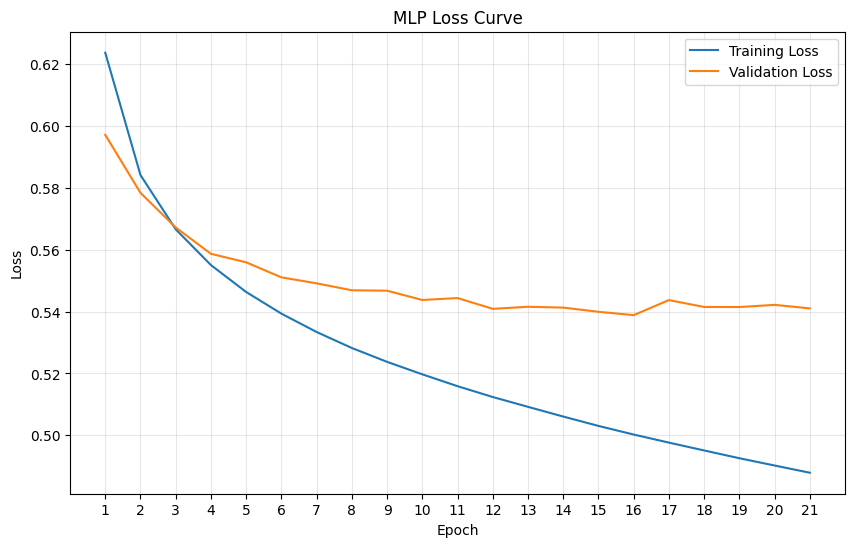

In [13]:
loss_df = pd.read_csv("/home/s2106664/msc_project/model_training/MLP_sigmoid/mlp_train_validation_losses_sigmoid.csv")

plt.figure(figsize=(10, 6))
plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Training Loss')
plt.plot(loss_df['epoch'], loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Loss Curve')
plt.legend()
plt.xticks(loss_df['epoch'])
plt.grid(alpha=0.3)
plt.savefig("MLP_loss_curve.png", dpi=300, bbox_inches='tight')
plt.show()

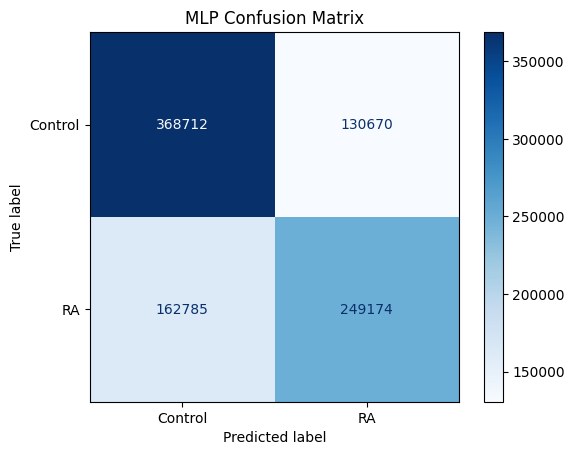

In [4]:
# Get predictions
with torch.no_grad():
    outputs = model(X_test_tensor)
    probs = torch.sigmoid(outputs) 
    predicted = (probs > 0.5).long().squeeze()  # Threshold at 0.5

predicted = predicted.cpu().numpy()

cm = confusion_matrix(y_test, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Control", "RA"])
disp.plot(cmap=plt.cm.Blues)
plt.title("MLP Confusion Matrix")
plt.savefig("MLP_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

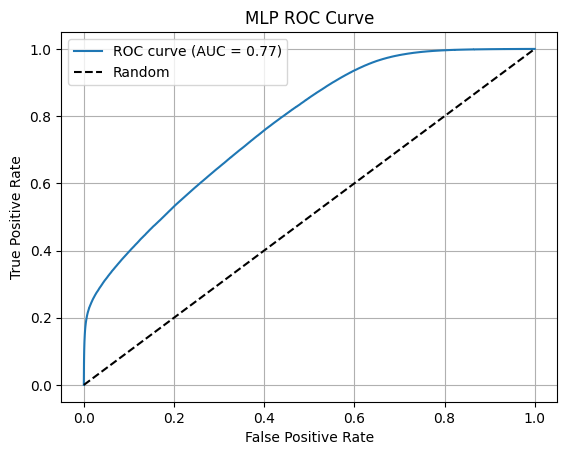

Probabilities (first 10): [4.8466316e-01 5.3268248e-01 7.0365047e-04 5.4254806e-01 4.1096836e-01
 3.1645305e-02 3.9626387e-01 5.7556391e-01 8.0699933e-01 3.5264927e-01]
True labels (first 10): [0 0 0 0 0 0 1 1 1 1]


In [8]:
with torch.no_grad():
    output = model(X_test_tensor)  # shape: (N, 1)
    probs = torch.sigmoid(output).cpu().numpy().squeeze()  # shape: (N,)
    y_true = y_test.values

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig("MLP_ROC_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Print some predictions and labels
print("Probabilities (first 10):", probs[:10])
print("True labels (first 10):", y_true[:10])

## 2.3 Mapping of predicted back to individual patient

In [2]:
complete_testing_set = pd.read_csv("/home/s2106664/msc_project/training_testing_dataset/complete_testing.csv")

In [7]:
complete_testing_set["predicted"] = predicted
complete_testing_set

,Sample_id,sequence_id,hypermutation_rate,cdr3_length,Factor_I,Factor_II,Factor_III,Factor_IV,Factor_V,np1_length,...,IGHV3-69-1,IGHV3-21,IGHJ5,IGHJ6,IGHJ4,IGHJ3,IGHJ1,IGHJ2,disease_status,predicted
0,B1168,M00689:14:000000000-A2E6E:1:1102:22688:21331|C...,0.000000,24.0,-0.303800,0.524900,-0.714300,0.147200,-0.123700,2.0,...,0,0,0,0,1,0,0,0,0,0
1,C0018,M00689:14:000000000-A2E6E:1:1102:26909:10237|C...,0.000000,36.0,-0.093000,0.322429,-0.241357,-0.083000,-0.066429,8.0,...,0,1,0,0,1,0,0,0,0,1
2,B1413,M00689:37:000000000-A3EUR:1:1110:22632:16560|C...,0.092000,45.0,-0.041000,0.340000,-0.413706,0.057471,-0.231412,3.0,...,0,0,1,0,0,0,0,0,0,0
3,C0022,M00689:29:000000000-A2YDG:1:2111:24316:20700|C...,0.000000,30.0,0.277500,0.370917,0.051500,-0.108750,0.335333,7.0,...,0,0,0,0,1,0,0,0,0,1
4,B8630,M00689:29:000000000-A2YDG:1:2111:17862:25393|C...,0.000000,54.0,-0.168900,-0.143000,-0.284150,0.584250,-0.108100,13.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911336,B1639,M00689:37:000000000-A3EUR:1:1112:6191:9138|CPR...,0.068493,54.0,-0.225850,0.346700,-0.551000,-0.042900,-0.300200,0.0,...,0,0,0,0,1,0,0,0,0,0
911337,A0003,M00689:37:000000000-A3EUR:1:1114:18468:12443|C...,0.021834,39.0,-0.337933,0.184800,1.050333,0.000600,0.552133,1.0,...,0,0,0,1,0,0,0,0,1,0
911338,A0005,M00689:14:000000000-A2E6E:1:1105:9156:13120|CP...,0.023622,48.0,-0.023889,0.279000,0.577833,0.096889,0.517278,6.0,...,0,0,0,0,1,0,0,0,1,0
911339,C0022,M00689:29:000000000-A2YDG:1:1101:22977:18401|C...,0.162437,21.0,-0.579778,0.591111,0.784556,0.285000,0.711556,3.0,...,0,0,0,0,1,0,0,0,0,0


In [8]:
grouped_testing = complete_testing_set.sort_values("Sample_id")
grouped_testing

,Sample_id,sequence_id,hypermutation_rate,cdr3_length,Factor_I,Factor_II,Factor_III,Factor_IV,Factor_V,np1_length,...,IGHV3-69-1,IGHV3-21,IGHJ5,IGHJ6,IGHJ4,IGHJ3,IGHJ1,IGHJ2,disease_status,predicted
114200,A0001,M00689:14:000000000-A2E6E:1:1105:9510:23349|CP...,0.000000,48.0,-0.129278,-0.001111,-0.749056,0.283278,-0.465111,1.0,...,0,0,0,0,0,1,0,0,1,0
446170,A0001,M00689:14:000000000-A2E6E:1:2114:17362:10014|C...,0.000000,54.0,-0.118550,0.723950,0.590100,-0.036100,0.603600,13.0,...,0,0,0,0,1,0,0,0,1,1
847338,A0001,M00689:14:000000000-A2E6E:1:2106:16940:26354|C...,0.000000,39.0,0.018333,0.368067,0.468400,0.123267,0.758867,1.0,...,0,0,0,1,0,0,0,0,1,0
128679,A0001,M00689:14:000000000-A2E6E:1:1104:11180:7400|CP...,0.000000,54.0,-0.077500,0.690400,0.534450,0.035350,0.480950,3.0,...,0,0,0,1,0,0,0,0,1,0
887075,A0001,M00689:14:000000000-A2E6E:1:1106:17959:18496|C...,0.000000,45.0,-0.222706,-0.255882,-0.239824,0.311529,-0.453706,5.0,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182596,C0022,M00689:29:000000000-A2YDG:1:2112:16032:18661|C...,0.087719,42.0,-0.253375,0.032500,-0.304750,0.015375,-0.527750,10.0,...,0,0,0,0,1,0,0,0,0,0
37921,C0022,M00689:29:000000000-A2YDG:1:2112:11510:11857|C...,0.056522,36.0,0.102643,0.084071,-0.170571,0.085714,-0.032571,1.0,...,0,0,0,0,1,0,0,0,0,0
705141,C0022,M00689:29:000000000-A2YDG:1:2101:16755:2447|CP...,0.137168,39.0,-0.061200,0.126800,0.643133,-0.161133,0.372333,6.0,...,0,0,1,0,0,0,0,0,0,0
182562,C0022,M00689:29:000000000-A2YDG:1:2107:19537:17749|C...,0.128319,30.0,-0.134667,0.102833,-0.014167,-0.173750,-0.041917,5.0,...,0,0,0,0,1,0,0,0,0,0


In [9]:
percentage_1 = (
    grouped_testing.groupby("Sample_id")["predicted"].value_counts(normalize=True).unstack(fill_value=0)[1] * 100
)
percentage_1 = percentage_1.reset_index().rename(columns={1: "percent_predicted_1"})
percentage_1

,Sample_id,percent_predicted_1
0,A0001,51.585824
1,A0003,57.491615
2,A0004,56.572395
3,A0005,53.187834
4,A0006,52.133379
5,A0007,58.736982
6,A0010,69.881707
7,A0011,55.514237
8,A0012,58.211907
9,A0013,75.314707


In [10]:
disease_status = []

for sample in percentage_1["Sample_id"]:
    if sample.startswith("A"):
        disease_status.append("RA")
    elif sample.startswith("B"):
        disease_status.append("HD")
    elif sample.startswith("C"):
        disease_status.append("HD")
    else:
        print(f"Unknown sample ID: {sample}")
        
percentage_1["disease_status"] = disease_status

In [12]:
percentage_1

,Sample_id,percent_predicted_1,disease_status
0,A0001,51.585824,RA
1,A0003,57.491615,RA
2,A0004,56.572395,RA
3,A0005,53.187834,RA
4,A0006,52.133379,RA
5,A0007,58.736982,RA
6,A0010,69.881707,RA
7,A0011,55.514237,RA
8,A0012,58.211907,RA
9,A0013,75.314707,RA


In [13]:
group_means = percentage_1.groupby("disease_status")["percent_predicted_1"].mean()
group_means

disease_status
HD    26.050218
RA    62.325695
Name: percent_predicted_1, dtype: float64

In [14]:
control_group = percentage_1[percentage_1["disease_status"] == "HD"]["percent_predicted_1"]
ra_group = percentage_1[percentage_1["disease_status"] == "RA"]["percent_predicted_1"]
group1 = control_group.values
group2 = ra_group.values

u_stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
print("U-statistic:", u_stat)
print("p-value:", p_value)

U-statistic: 0.0
p-value: 3.567368795444174e-06


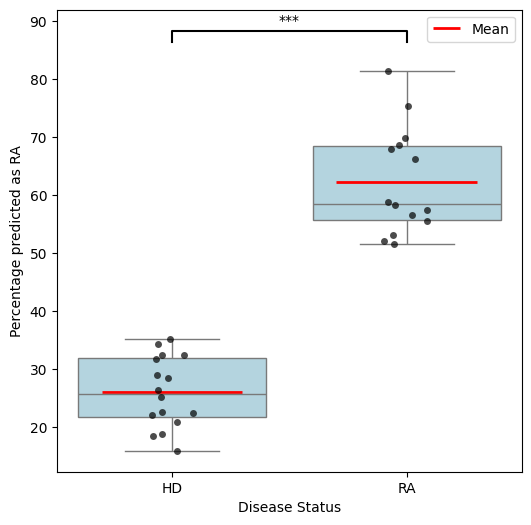

In [25]:
plt.figure(figsize=(6, 6))
sns.boxplot(x="disease_status", y="percent_predicted_1", data=percentage_1, color="lightblue", order = ["HD", "RA"])  # boxplot without outlier dots
sns.stripplot(x="disease_status", y="percent_predicted_1", data=percentage_1, color="black", alpha=0.7, jitter=True)

group_means = percentage_1.groupby("disease_status")["percent_predicted_1"].mean()

# Add horizontal lines at group means
for i, group in enumerate(["HD", "RA"]):
    mean_val = group_means[group]
    plt.hlines(y=mean_val, xmin=i - 0.3, xmax=i + 0.3, colors="red", linestyles="-", linewidth=2, label="Mean" if i == 0 else "")

# Determine significance level
if p_value < 0.001:
    stars = '***'
elif p_value < 0.01:
    stars = '**'
elif p_value < 0.05:
    stars = '*'
else:
    stars = 'ns'

# Add significance line
x1, x2 = 0, 1  # 'HD' and 'RA' positions
y, h, col = percentage_1['percent_predicted_1'].max() + 5, 2, 'black' 
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+0.5, stars, ha='center', va='bottom', color=col)

plt.legend()
plt.ylabel("Percentage predicted as RA")
plt.xlabel("Disease Status")
plt.savefig("MLP_box_plot.png", dpi=300, bbox_inches='tight')
plt.show()